In [73]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rnd
import sklearn.cluster as skcl

In [105]:
# two blobs of data
n = 1000
N = 3 * n
Lx = 10
Ly = 5
X1 = rnd.uniform(0, Lx*0.25, (n, 2))
X2 = rnd.uniform(0.75*Lx, Lx, (3*n, 2))
X1[:, 1] *= Ly / Lx
X1[:, 0] += Lx*0.25
X2[:, 1] *= Ly / Lx

X3 = np.append(
    rnd.uniform(Lx*0.25, Lx*0.5, (2*n, 1)),
    rnd.uniform(Ly*0.5, 0.75*Ly, (2*n, 1))
).reshape((2*n, 2))
X = np.concatenate((X1, X2, X3), axis=0)


X.shape


(6000, 2)

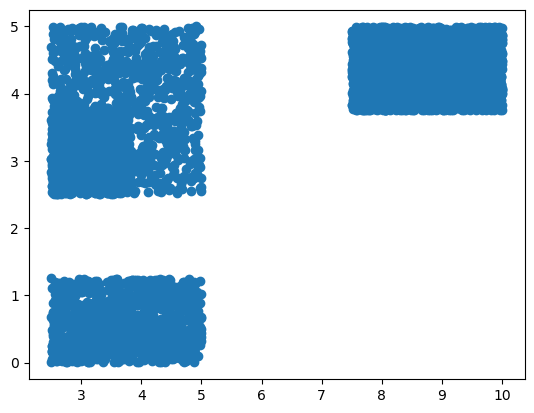

In [106]:

# plot the data
plt.scatter(X[:, 0], X[:, 1])
# plt.xlim(0, Lx)
# plt.ylim(0, Ly)
plt.show()


In [107]:
from sklearn.preprocessing import StandardScaler
from numba import jit


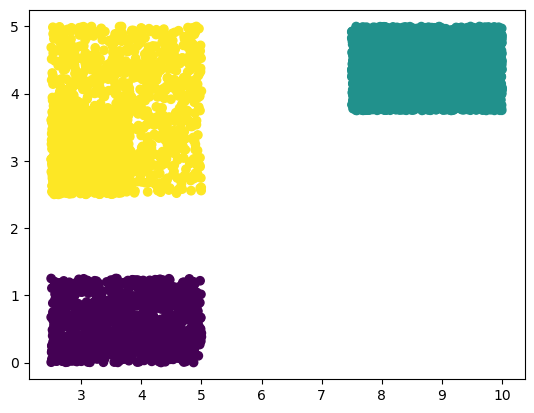

In [108]:
# Naive db scan
X_scaled = StandardScaler().fit_transform(X)

db = skcl.dbscan(X_scaled, eps=0.3, min_samples=5)
plt.scatter(X[:, 0], X[:, 1], c=db[1])

In [109]:
@jit(nopython=True)
def distance_periodic(X, Y, periods):
    dims = periods.shape[0]
    n = X.shape[0]
    dist = 0 
    for d in range(dims):
        dist += (np.abs(X[d] - Y[d]) / periods[d])**2
    return np.sqrt(dist)
    
    # dx = np.abs(x[0] - y[0]) / Lx
    # dy = np.abs(x[1] - y[1]) / Ly 
    # if dx > 0.5:
    #     dx = 1 - dx
    # if dy > 0.5:
    #     dy = 1 - dy
    # return np.sqrt(dx**2 + dy**2)

In [110]:
from sklearn.neighbors import NearestNeighbors


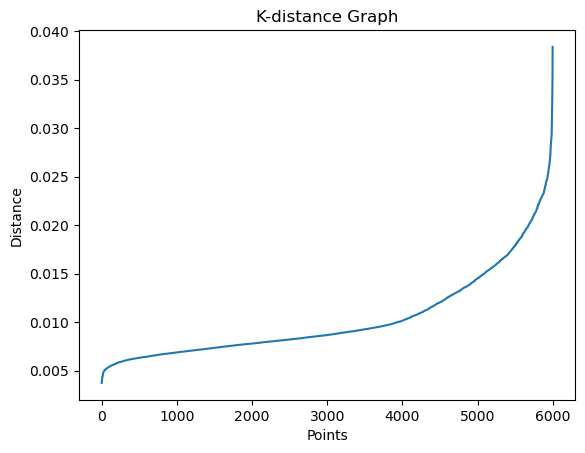

In [111]:
neighbours = NearestNeighbors(n_neighbors=10, metric=distance_periodic, metric_params={'periods': np.array([Lx, Ly])})
neighbours.fit(X)
dist, index = neighbours.kneighbors(X)
distances = np.sort(dist[:, -1])
plt.plot(distances)
plt.title('K-distance Graph')
plt.xlabel('Points')
plt.ylabel('Distance')
plt.show()

In [112]:
eps = distances[int(0.95 * len(distances))] # 95% of the distances
eps

0.020249717981356274

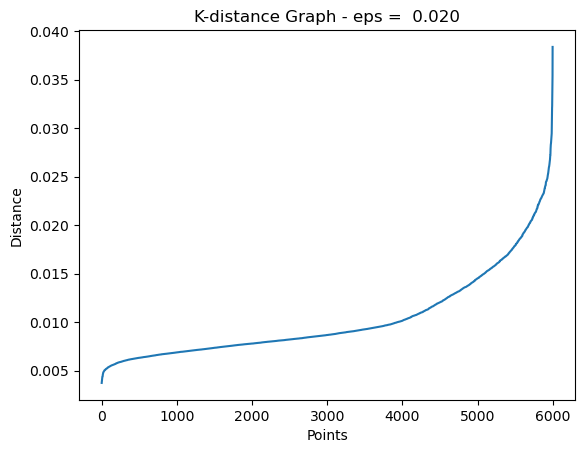

0.020249717981356274

In [113]:
def neighbours_heuristic(X, periods, n_neighbours, quantile = 0.95, plot = False):
    neighbours = NearestNeighbors(n_neighbors=10, metric=distance_periodic, metric_params={'periods': np.array([Lx, Ly])})
    neighbours.fit(X)
    dist, index = neighbours.kneighbors(X)
    distances = np.sort(dist[:, -1])
    eps = distances[int(quantile * len(distances))]
    if plot:
        plt.plot(distances)
        plt.title('K-distance Graph')
        plt.xlabel('Points')
        plt.ylabel('Distance')
        plt.title(f'K-distance Graph - eps = {eps : .3f}')
        plt.show()
    return eps

neighbours_heuristic(X, np.array([Lx, Ly]), 10, 0.95, True)

Number of clusters: 3


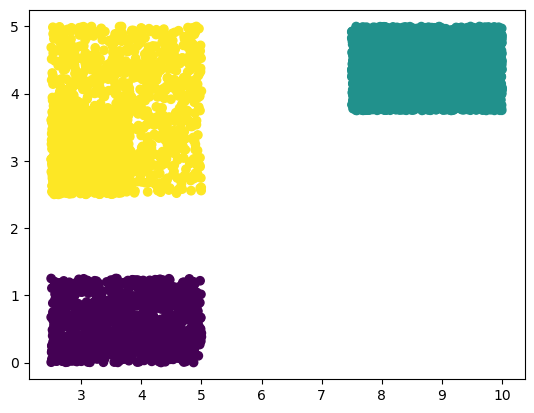

In [114]:

db2 = skcl.dbscan(X, metric=distance_periodic, eps=eps, min_samples=5, metric_params={'periods': np.array([Lx, Ly])})
n_clust = len(set(db2[1]))
print(f"Number of clusters: {n_clust}")


plt.scatter(X[:, 0], X[:, 1], c=db2[1])
plt.show()



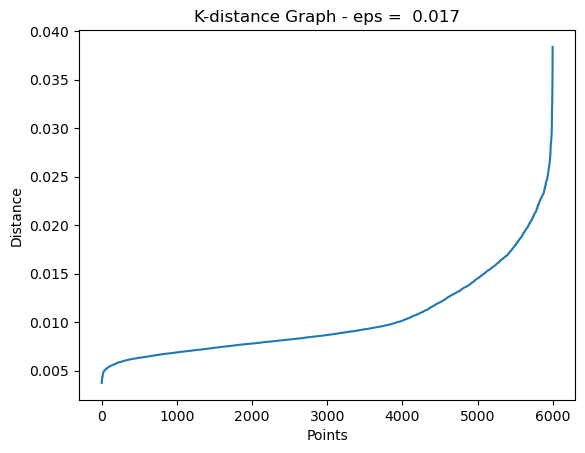

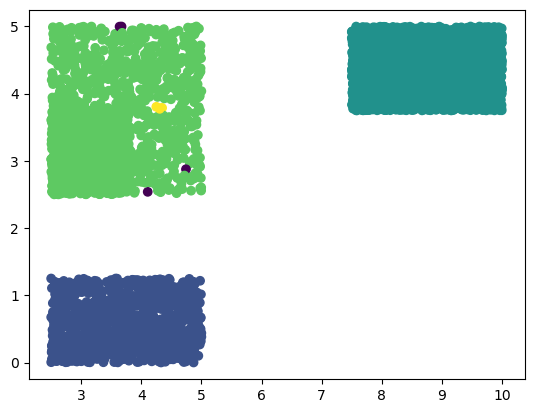

In [128]:
def clustering_periodic_labels(X, periods, n_neighbours, quantile = 0.95, plotBool = False):
    eps = neighbours_heuristic(X, periods, n_neighbours, quantile, plotBool)
    db = skcl.dbscan(X, metric=distance_periodic, eps=eps, min_samples=n_neighbours, metric_params={'periods': periods})
    return db[1]

lbl = clustering_periodic_labels(X, np.array([Lx, Ly]),3, quantile = 0.9, plotBool=False)
plt.scatter(X[:, 0], X[:, 1], c=lbl)